# Forecasting Multiple Time Series

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Vector Autoregression (VAR) Model

The vector autoregression (VAR) model captures the relationship between multiple
series as they change over time. In this model, each series has an impact on the other,
unlike the SARIMAX model where the exogenous variable had an impact on the target, but not the other way around. 

In [5]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


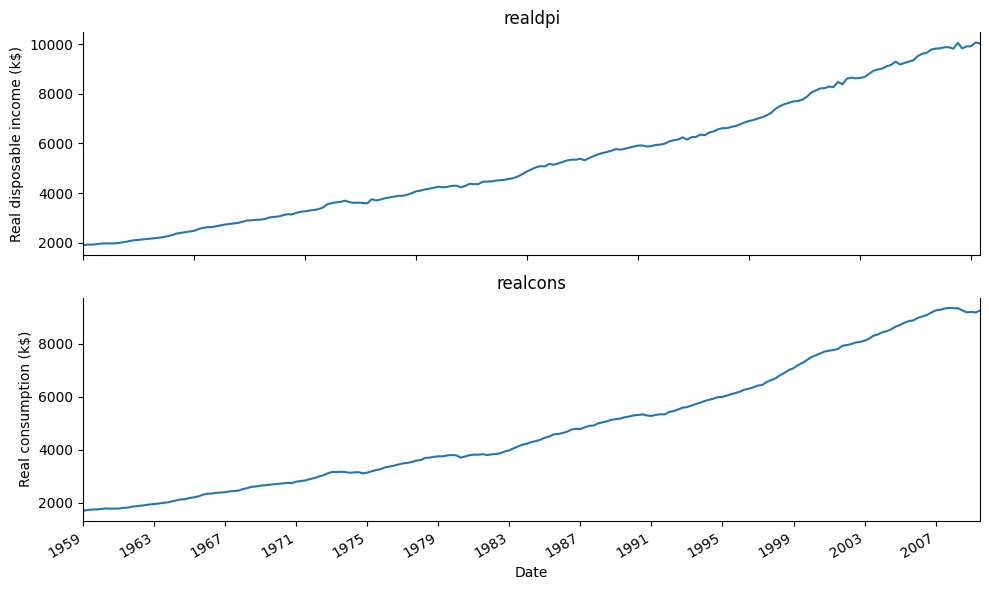

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.set_xlim(0, 202) 

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.set_xlim(0, 202) 

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

Real disposable income (realdpi) and real consumption (realcons) in the United States from
1959 to 2009. The data is collected quarterly and is expressed in thousands of US dollars. Both series have a
similar shape and trend over time.

#### Important: Both time series must be stationary before they are used in the VAR(p) model.

In [9]:
# Augmented Dickey-Fuller (ADF) test for 'realdpi'
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
if ad_fuller_result_1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

print('\n---------------------\n')

# Augmented Dickey-Fuller (ADF) test for 'realcons'
ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
if ad_fuller_result_2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

print()

realdpi
ADF Statistic: 2.9860253519546878
p-value: 1.0
p-value > alpha; H0: Not Stationary

---------------------

realcons
ADF Statistic: 1.5499123380509559
p-value: 0.9976992503412904
p-value > alpha; H0: Not Stationary



In [10]:
realdpi_diff = macro_econ_data['realdpi'].diff()[1:]   # First-Order differencing for 'realdpi'
ad_fuller_result_1 = adfuller(realdpi_diff)

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
if ad_fuller_result_1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

print('\n---------------------\n')

realcons_diff = macro_econ_data['realcons'].diff()[1:] # First-Order differencing for 'realcons'
ad_fuller_result_2 = adfuller(realcons_diff)

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
if ad_fuller_result_2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")
    
print()

realdpi
ADF Statistic: -8.864893340673012
p-value: 1.449360615910768e-14
p-value < alpha; Ha: Stationary

---------------------

realcons
ADF Statistic: -4.2043060808452495
p-value: 0.0006479282158627493
p-value < alpha; Ha: Stationary



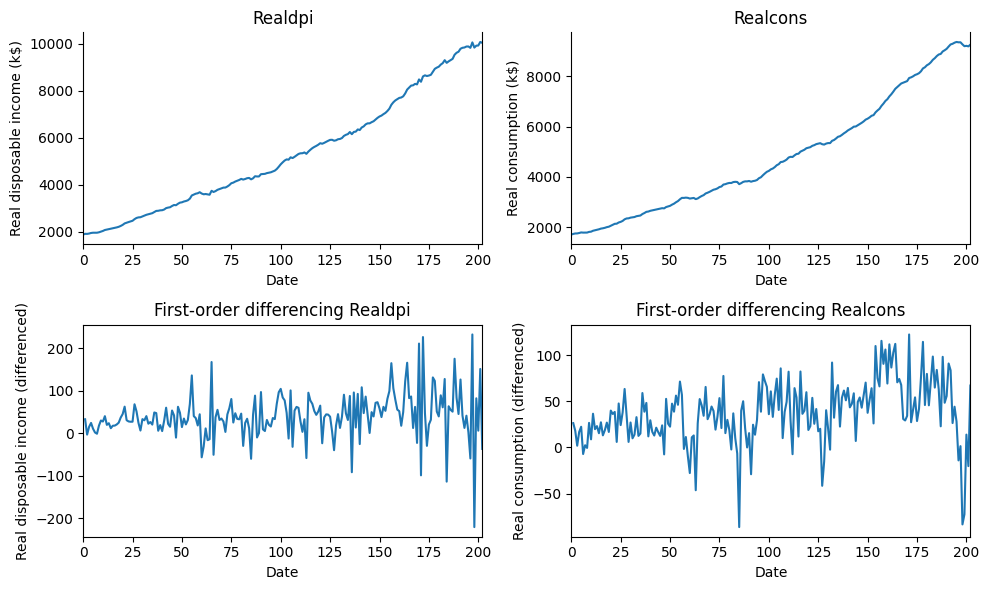

In [11]:
# Set up the figure for 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# 1. Plot 'realdpi'
axes[0, 0].plot(macro_econ_data['realdpi'])
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Real disposable income (k$)')
axes[0, 0].set_title('Realdpi')
axes[0, 0].spines['top'].set_alpha(0)
axes[0, 0].set_xlim(0, 202)

# 2. Plot 'realcons'
axes[0, 1].plot(macro_econ_data['realcons'])
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Real consumption (k$)')
axes[0, 1].set_title('Realcons')
axes[0, 1].spines['top'].set_alpha(0)
axes[0, 1].set_xlim(0, 202)

# 3. Plot First-order differencing realdpi
axes[1, 0].plot(realdpi_diff)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Real disposable income (differenced)')
axes[1, 0].set_title('First-order differencing Realdpi')
axes[1, 0].set_xlim(0, 202)

# 4. Plot First-order differencing realcons
axes[1, 1].plot(realcons_diff)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Real consumption (differenced)')
axes[1, 1].set_title('First-order differencing Realcons')
axes[1, 1].set_xlim(0, 202)

# Layout adjustments
plt.tight_layout()
plt.show()

*Both time series, 'First-order differencing for Realdpi' and  'First-order differencing for Realcons', are stationary. As mentioned before, the VAR(p) model requires the time series to be stationary. We can thus use the transformed series for modeling, and we will need to integrate the
forecasts to bring them back to their original scales*.

#### Fitting many VAR(p) models to select the one with the smallest Akaike information criterion (AIC)

In [14]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(15)):  # Vary the order p from 0 to 14
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [15]:
# Select only realdpi and realcons, as they are the only two variables of interest in this case
endog = macro_econ_data[['realdpi', 'realcons']]

# Difference both series, as the ADF test shows that a first-order differencing makes them stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]  # The first 162 data points go for training 
test = endog_diff[162:]   # The last 40 points go for the test set

# Run the optimize_VAR function using train set
result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,3,3123.070081
1,5,3123.708523
2,6,3126.855594
3,4,3129.194052
4,2,3130.091668
5,7,3133.395717
6,1,3134.333343
7,8,3137.149015
8,9,3140.367180
9,10,3147.838568


Running the function returns a DataFrame in which we see that p = 3 has the lowest AIC value of all. Therefore, the selected model is a VAR(3) model, meaning that the past three values of each time series are used to forecast the other time series.

Following the modeling procedure, we must now use the Granger causality test 
Recall that the VAR model assumes that past values of realcons are useful in predicting realdpi and that past values of realdpi are useful in predicting realcons. Thi 
relationship must be tested.

In [17]:
print('realcons Granger-causes realdpi?')
print('------------------')
# Here we thus test if realcons Granger-causes realdpi
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3]) 

# Extracting the p-value from the'ssr_ftest' tuple
ssr_p_value_1 = granger_1[3][0]['ssr_ftest'][1] 
print()

if ssr_p_value_1 < 0.05:
    print("Yes. p-value < alpha; Ha: Granger causality exists.")
else:
    print("No. p-value > alpha; H0: No Granger causality.")


print('\nrealdpi Granger-causes realcons?')
print('------------------')
# Here we test if realdpi Granger-causes realcons
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

# Extracting the p-value from the'ssr_ftest' tuple
ssr_p_value_2 = granger_1[3][0]['ssr_ftest'][1] 
print()

if ssr_p_value_2 < 0.05:
    print("Yes. p-value < alpha; Ha: Granger causality exists.")
else:
    print("No. p-value > alpha; H0: No Granger causality.")

realcons Granger-causes realdpi?
------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

Yes. p-value < alpha; Ha: Granger causality exists.

realdpi Granger-causes realcons?
------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3

Yes. p-value < alpha; Ha: Granger causality exists.


    realdpi Granger-causes realcons, and realcons Granger-causes realdpi.

**Our VAR(3) model is thus valid. In the event that one variable does not Granger-cause the
other, the VAR(p) model becomes invalid, and it cannot be used. In that case, we must
use the SARIMAX model and predict each time series individually.**

In [20]:
# Define a VAR(3) model on train set
best_model = VARMAX(train, order=(3,0))

# Fit the model
best_model_fit = best_model.fit(disp=False)

# Display the summary
best_model_fit.summary()

Dep. Variable:,"['realdpi', 'realcons']",No. Observations:,162
Model:,VAR(3),Log Likelihood,-1544.535
,+ intercept,AIC,3123.070
Date:,"Wed, 19 Feb 2025",BIC,3175.559
Time:,13:16:40,HQIC,3144.381
Sample:,0,,
,- 162,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.03",Jarque-Bera (JB):,"43.85, 4.35"
Prob(Q):,"0.91, 0.87",Prob(JB):,"0.00, 0.11"
Heteroskedasticity (H):,"4.44, 3.59",Skew:,"0.14, -0.21"


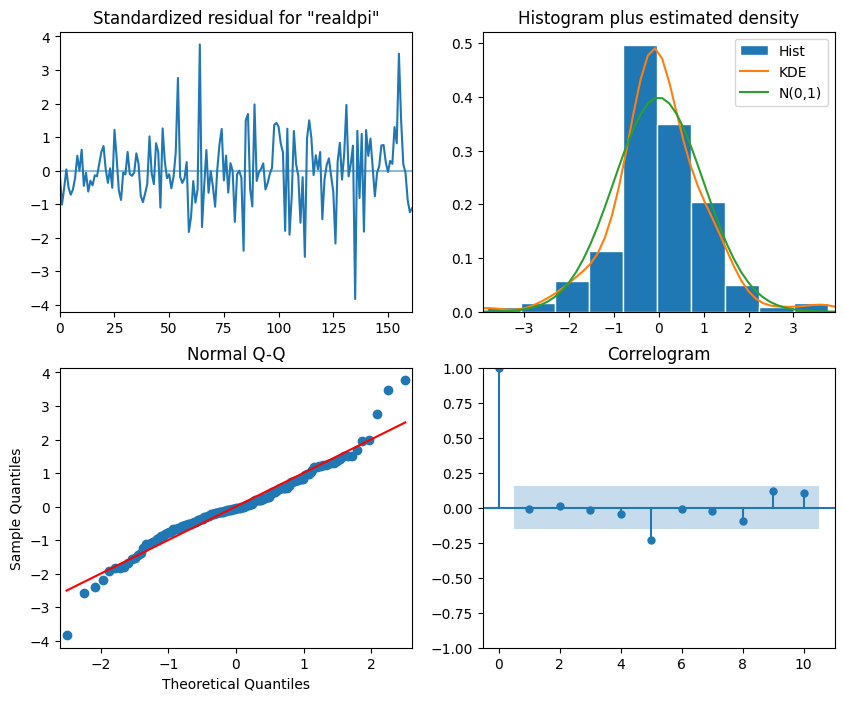

In [21]:
# Diagnostic plots for the model, including residuals and other model checks
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

# Passing variable=0 specifies that we want plots for the residuals of realdpi, since it is the first variable that was passed to the VAR model

*Residuals analysis of realdpi. The standardized residuals seem to have no trend and
constant variance, which is in line with white noise. The histogram also closely resembles the shape of
a normal distribution. This is further supported by the Q-Q plot, which shows a fairly straight line that lies
on y = x, although we can see some curvature at the extremities. Finally, the correlogram shows no
significant coefficients except at lag 5. However, this is likely due to chance, since there are no
preceding significant coefficients. Thus, we can conclude that the residuals are close to white noise.*

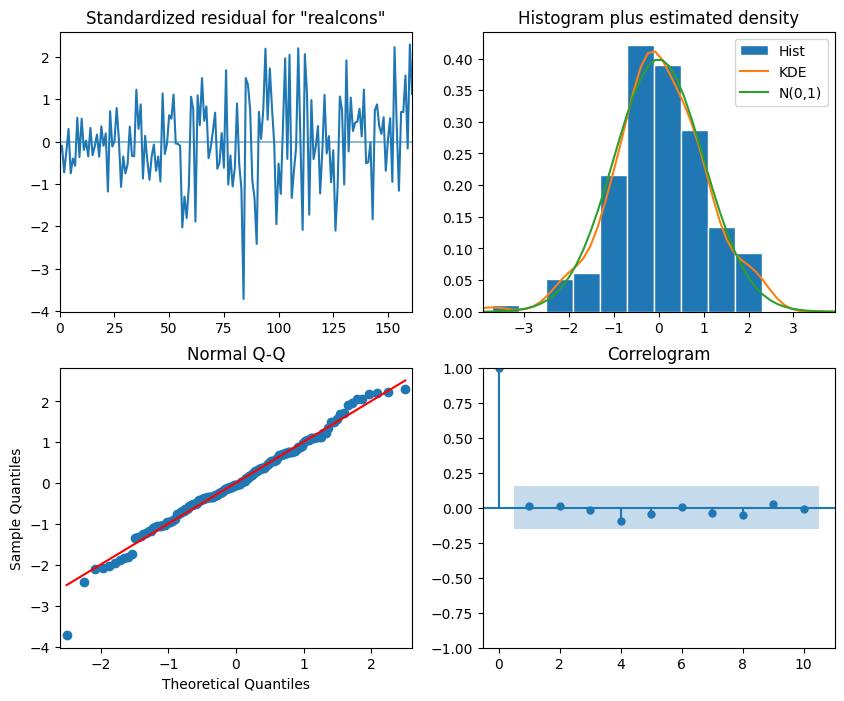

In [23]:
# Diagnostic plots for the model, including residuals and other model checks
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

# Passing variable=1 specifies that we want plots for the residuals of realcons, since it is the second variable that was passed to the VAR model

*Residuals analysis of realcons. The top-left plot shows the residuals over time, and you
can see that there is no trend and constant variance, which is in line with the behavior of white noise.
At the top right, the distribution is very close to a normal distribution. This is further supported by the
Q-Q plot at the bottom left, which displays a fairly straight line that lies on y = x. Finally, the correlogram
at the bottom right shows that there are no significant autocorrelation coefficients after lag 0.
Therefore, the residuals are close to white noise.*

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract the residuals (errors) from the fitted model
residuals_realdpi = best_model_fit.resid['realdpi']

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals_realdpi = acorr_ljungbox(residuals_realdpi, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals_realdpi['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals_realdpi

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.011646,0.914060
2,0.029457,0.985379
3,0.075687,0.994586
4,0.378056,0.984234
5,9.143186,0.103487
6,9.166061,0.164452
7,9.270740,0.233798
8,10.812743,0.212537
9,13.318832,0.148702
10,15.287954,0.121911


In [26]:
# Extract the residuals (errors) from the fitted model
residuals_realcons = best_model_fit.resid['realcons']

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals_realcons = acorr_ljungbox(residuals_realcons, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals_realcons['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals_realcons

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.023588,0.877938
2,0.068582,0.966290
3,0.068660,0.995312
4,0.235537,0.993586
5,0.377501,0.995927
6,0.787221,0.992412
7,1.015069,0.994582
8,2.150413,0.976050
9,2.437165,0.982526
10,2.442858,0.991683


Since the model passed both the qualitative and quantitative aspects of residual
analysis, we can move on to forecasting realcons and realdpi using a VAR(3) model.
We will compare the VAR(3) model to a baseline that simply predicts the last observed
value. We’ll forecast four steps into the future, which is equivalent to forecasting one
full year as the data is sampled quarterly. We’ll thus perform a rolling forecast four
steps into the future over the entire length of the test set.

In [28]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':

        realdpi_pred_VAR = []    # Initialize two empty lists to hold the predictions for realdpi and realcons
        realcons_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0)) #<==== VAR(3)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']     # Extract the predictions for realdpi
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']   # Extract the predictions for realcons
            
            realdpi_pred_VAR.extend(oos_pred_realdpi)     # Extend the lists with the new predictions for each variable
            realcons_pred_VAR.extend(oos_pred_realcons)    
        
        return realdpi_pred_VAR, realcons_pred_VAR
    
    elif method == 'last':       # For the baseline, we’ll also use two lists to hold the predictions for each variable and return them at the end
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last      # Return both lists of predictions for realdpi and realcons

We can now use this function to produce the forecasts for realdpi and realcons using the VAR(3) model.

In [30]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4    # The window is 4, since we want to forecast four time steps into the future at a time, which is equivalent to 1 year

# Generate forecasts using the 'VAR' method with rolling_forecast function
realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

Recall that the VAR(3) model requires the series to be stationary, meaning that we
have transformed forecasts. We must then integrate them using the cumulative sum to
bring them back to the original scale of the data.

In [32]:
# Slice the 'endog' DataFrame starting from row 163 to create a 'test' set
test = endog[163:]  

test['realdpi_pred_VAR'] = pd.Series()    # Initialize an empty 'realdpi_pred_VAR' column in the 'test' DataFrame
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)  # Integrate the forecasts using the cumulative sum

test['realcons_pred_VAR'] = pd.Series()  # Initialize an empty 'realcons_pred_VAR' column in the 'test' DataFrame
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)  # Integrate the forecasts using the cumulative sum

test  

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.225436,7354.324973
164,8053.4,7501.3,7897.191819,7430.257899
165,8135.9,7571.8,7960.567957,7496.633321
166,8222.3,7645.9,8014.759322,7556.618023
167,8234.6,7713.5,8080.707471,7631.002170
168,8296.5,7744.3,8142.399086,7692.851914
169,8273.7,7773.5,8200.132090,7753.873091
170,8484.5,7807.7,8259.372991,7812.543024
171,8385.5,7930.0,8264.396980,7864.643623
172,8611.6,7957.3,8320.869302,7895.068367


At this point, test contains the actual values of the test set and the predictions from
the VAR(3) model. We can now add the forecasts from our baseline method, which
simply predicts the last known value for the next four timesteps.

In [34]:
# Generate forecasts using the 'last' method with rolling_forecast function
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last     # Add the 'realdpi_pred_last' predictions to the 'test' DataFrame
test['realcons_pred_last'] = realcons_pred_last   # Add the 'realcons_pred_last' predictions to the 'test' DataFrame

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.225436,7354.324973,7716.0,7199.9
164,8053.4,7501.3,7897.191819,7430.257899,7716.0,7199.9
165,8135.9,7571.8,7960.567957,7496.633321,7716.0,7199.9
166,8222.3,7645.9,8014.759322,7556.618023,7716.0,7199.9
167,8234.6,7713.5,8080.707471,7631.002170,8135.9,7571.8
168,8296.5,7744.3,8142.399086,7692.851914,8135.9,7571.8
169,8273.7,7773.5,8200.132090,7753.873091,8135.9,7571.8
170,8484.5,7807.7,8259.372991,7812.543024,8135.9,7571.8
171,8385.5,7930.0,8264.396980,7864.643623,8273.7,7773.5
172,8611.6,7957.3,8320.869302,7895.068367,8273.7,7773.5


Now test holds the actual values of the test set, the predictions from the VAR(3)
model, and the predictions from the baseline method. Everything is set for us to visualize the forecasts and evaluate the forecasting methods using the mean absolute percentage error (MAPE). 

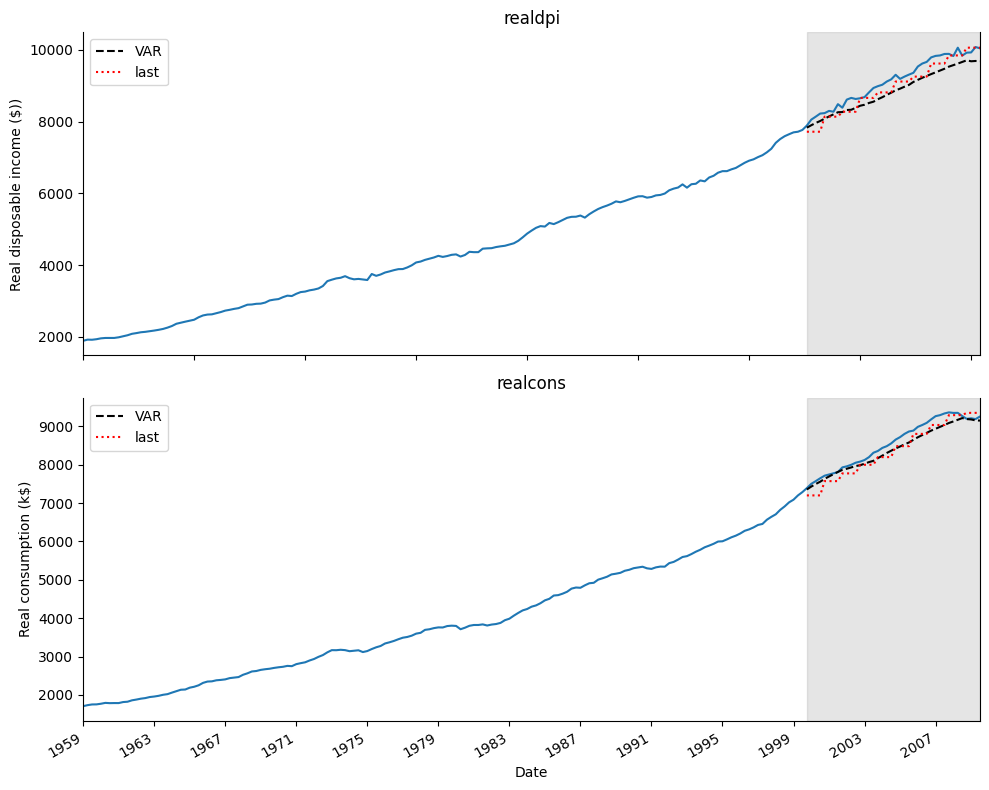

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(0, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(0, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(0, 202)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/Forecasting.png', dpi=300)

*Forecasts of realdpi and realcons. You can see that the predictions from the VAR(3) model,
shown as a dashed line, closely follow the actual values of the test set. You’ll also notice that the dotted curve
from the baseline method shows little steps, which makes sense since we are forecasting a constant value over
four timesteps.*

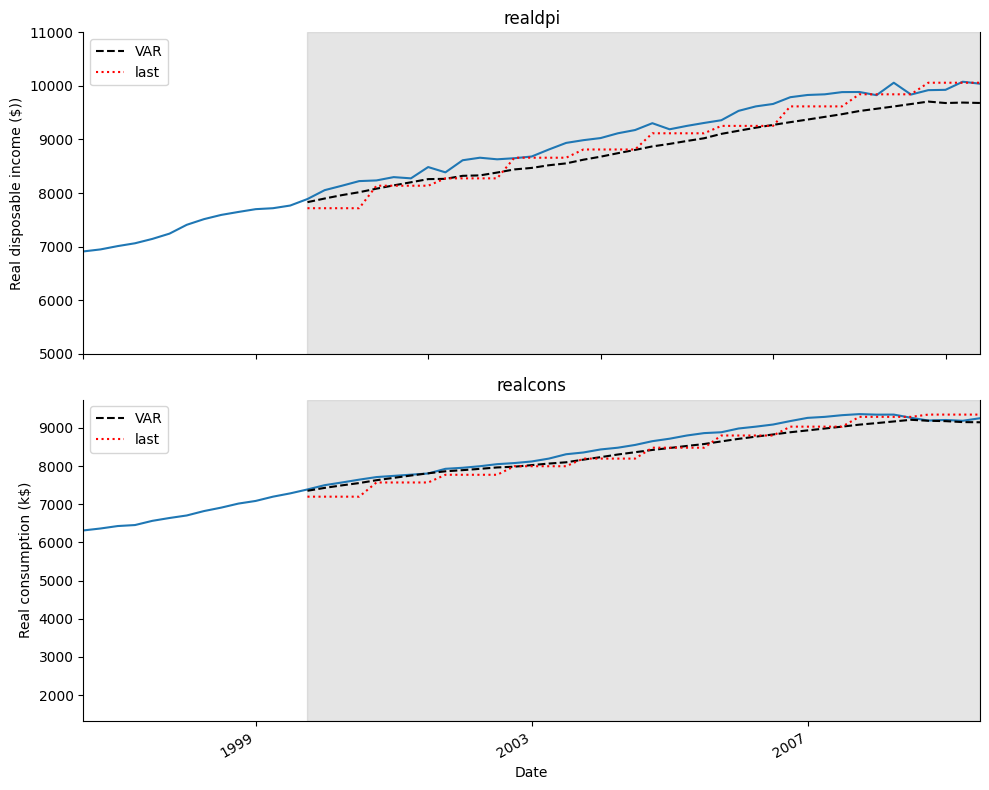

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(150, 202)
ax1.set_ylim(5000, 11000)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(150, 202)
ax1.set_ylim(5000, 11000)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(150, 202)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/ForecastingZoom.png', dpi=300)

In [39]:
# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
# Calculate MAPE for each forecast
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

# Display MAPE results
print(f'realdpi MAPE for last-value Baseline: {mape_realdpi_last:.2f}')
print(f'    realdpi MAPE for VAR(3) Forecast: {mape_realdpi_VAR:.2f}')
print()
print(f'realcons MAPE for last-value Baseline: {mape_realcons_last:.2f}')
print(f'    realcons MAPE for VAR(3) Forecast: {mape_realcons_VAR:.2f}')

realdpi MAPE for last-value Baseline: 2.26
    realdpi MAPE for VAR(3) Forecast: 3.14

realcons MAPE for last-value Baseline: 2.46
    realcons MAPE for VAR(3) Forecast: 1.77


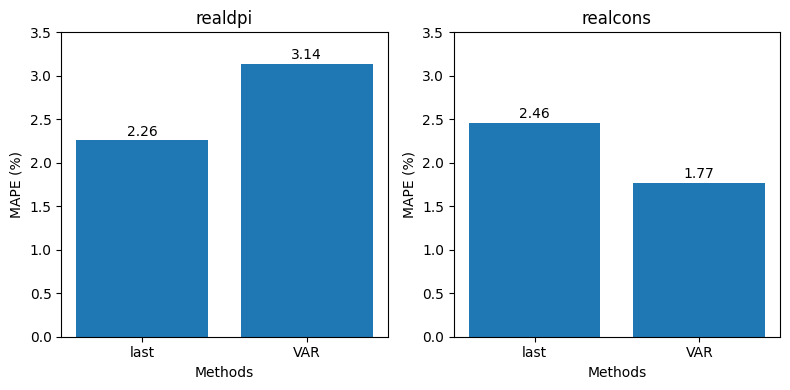

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3.5)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

*The MAPE of the forecast for realdpi and realcons. You can see that the VAR(3) model
performs worse than the baseline in the case of realdpi. However, the VAR(3) model performs better than the
baseline for realcons.*

### Summary

    The vector autoregression model, VAR(p), captures the relationship between multiple series as they change over time. In this model, each series has an impact on the others.

    A VAR(p) model is valid only if each time series Granger-causes the others. This is determined using the Granger causality test.

    The null hypothesis of the Granger causality test states that one time series does not Granger-cause the other. If the p-value is less than 0.05, we reject the null hypothesis and conclude that the first time series Granger-causes the other.